#Imports

In [ ]:
import pandas as pd
from google.colab import drive
from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch
import numpy as np
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, recall_score, precision_score, roc_curve, auc
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy
import matplotlib.pyplot as plt


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


#Plots & Helper Functions

## metrics

In [ ]:
def metrics(y_true, y_pred, threshold=0.5):

  #convert to numpy --> isinstance: is this object an instance of this class
  if isinstance(y_true, torch.Tensor):
    y_true = y_true.cpu().numpy()
  if isinstance(y_pred, torch.Tensor):
    y_pred = y_pred.cpu().numpy()


  y_pred_bin = (y_pred >= threshold).astype(int)
  y_true_bin = y_true.astype(int)


  metrics = {
        "accuracy": accuracy_score(y_true_bin, y_pred_bin),
        "f1": f1_score(y_true_bin, y_pred_bin, average='macro'), ##micro and macro same in binary classification
        "confusion_matrix": confusion_matrix(y_true_bin, y_pred_bin),
        # "auc_score": roc_auc_score(y_true_bin, y_pred_bin),
        "auc_score": roc_auc_score(y_true_bin, y_pred),
        "recall_score": recall_score(y_true_bin, y_pred_bin),
        "precision_score": precision_score(y_true_bin, y_pred_bin)
    }

  return metrics



## Plots

In [ ]:
def plot_history(history):
    plt.figure(figsize=(15, 10))

    #loss
    plt.subplot(2, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)

    #accuracy
    plt.subplot(2, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)


    plt.tight_layout()
    plt.show()

In [ ]:
def plot_roc(y_true, y_pred_probs, label_name="Hotspot"):
    if torch.is_tensor(y_true):
        y_true = y_true.cpu().numpy()
    if torch.is_tensor(y_pred_probs):
        y_pred_probs = y_pred_probs.cpu().numpy()
    y_true = y_true.ravel()
    y_pred_probs = y_pred_probs.ravel()

    fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='navy', lw=2, label=f'{label_name} (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    print(f"AUC = {roc_auc:.3f}")

# Dataset


## S. cerevisae

In [ ]:
def create_hotspot_splits(data, seq_col="sequence", label_col="label",
                          test_size=0.2, val_size=0.5, random_state=42):

    # Keep only sequence + label col
    data = data[[seq_col, label_col]].copy()

    train_df, temp_df = train_test_split(
        data, test_size=test_size, stratify=data[label_col], random_state=random_state
    )

    val_df, test_df = train_test_split(
        temp_df, test_size=val_size, stratify=temp_df[label_col], random_state=random_state
    )

    train_seqs = train_df[seq_col].tolist()
    val_seqs   = val_df[seq_col].tolist()
    test_seqs  = test_df[seq_col].tolist()

    train_labels = train_df[label_col].to_numpy(dtype=np.float32)
    val_labels   = val_df[label_col].to_numpy(dtype=np.float32)
    test_labels  = test_df[label_col].to_numpy(dtype=np.float32)

    return train_seqs, train_labels, val_seqs, val_labels, test_seqs, test_labels

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/715/yps128_data.csv")  # columns: ID, sequence, label

train_seqs, train_labels, val_seqs, val_labels, test_seqs, test_labels = create_hotspot_splits(data)

print(f"Train: {len(train_seqs)}\nVal: {len(val_seqs)}\nTest: {len(test_seqs)}")

Train: 3728
Val: 466
Test: 466


In [ ]:
np.save("/content/drive/MyDrive/715/train_labels.npy", train_labels)
np.save("/content/drive/MyDrive/715/test_labels.npy", test_labels)
np.save("/content/drive/MyDrive/715/val_labels.npy", val_labels)

## S. paradoxus

In [ ]:
spar_data = pd.read_csv("/content/drive/MyDrive/715/paradoxus/spar_data.csv")
spar_labels = spar_data["label"].to_numpy(dtype=np.float32)
spar_seqs = spar_data["sequence"].tolist()
np.save("/content/drive/MyDrive/715/paradoxus/spar_labels.npy", spar_labels)

## S. mikatae


In [ ]:
smik_data = pd.read_csv("/content/drive/MyDrive/715/Smik/smik_data.csv")
smik_labels = smik_data["label"].to_numpy(dtype=np.float32)
smik_seqs = smik_data["sequence"].tolist()
np.save("/content/drive/MyDrive/715/Smik/smik_labels.npy", smik_labels)

## S.  kudriavzevii

In [ ]:
skud_data = pd.read_csv("/content/drive/MyDrive/715/Skud/skud_data.csv")
skud_labels = skud_data["label"].to_numpy(dtype=np.float32)
skud_seqs = skud_data["sequence"].tolist()
np.save("/content/drive/MyDrive/715/Skud/skud_labels.npy", skud_labels)

# EXTRACT EMBEDDINGS


##Load Model


In [ ]:
model_name = "InstaDeepAI/nucleotide-transformer-v2-500m-multi-species"

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForMaskedLM.from_pretrained(
    model_name,
    trust_remote_code=True,
    output_hidden_states=True
)
model.eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/129 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/101 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

esm_config.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/InstaDeepAI/nucleotide-transformer-v2-500m-multi-species:
- esm_config.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_esm.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/InstaDeepAI/nucleotide-transformer-v2-500m-multi-species:
- modeling_esm.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/1.99G [00:00<?, ?B/s]

EsmForMaskedLM(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(4107, 1024, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(2050, 1024, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-28): 29 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((1024,), eps=1e-12

## Embedding Function


In [ ]:

def get_yeast_embeddings(sequences, model, tokenizer, batch_size=8, save_path=None, max_length=1000):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    embeddings = []

    for i in tqdm(range(0, len(sequences), batch_size), desc="Embedding batches"):
        batch_seqs = sequences[i:i+batch_size]

        # Tokenize and pad
        inputs = tokenizer(batch_seqs,
                           return_tensors="pt",
                           padding=True,
                           truncation=True,
                           max_length=max_length).to(device)

        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)

            # Average the last 4 layers: shape [batch, seq_len, embed_dim]
            hidden_states = torch.stack(outputs.hidden_states[-4:], dim=0).mean(0)

            # Masked mean pooling over sequence length
            mask = inputs['attention_mask'].unsqueeze(-1)  # [batch, seq_len, 1]
            summed = (hidden_states * mask).sum(dim=1)     # [batch, embed_dim]
            counts = mask.sum(dim=1).clamp(min=1e-9)       # avoid div by 0
            batch_embs = (summed / counts).cpu().numpy()   # [batch, embed_dim]

            embeddings.append(batch_embs)

    all_embeddings = np.vstack(embeddings)  # [num_sequences, embed_dim]

    if save_path:
        np.save(save_path, all_embeddings)
        print(f"Saved embeddings to {save_path}")

    return all_embeddings

## S. cerevisae embeddings --> for training

In [ ]:
# train_embeddings = get_yeast_embeddings(train_seqs,
#                                         model,
#                                         tokenizer,
#                                         save_path = "/content/drive/MyDrive/715/train_embeddings.npy")

# test_embeddings = get_yeast_embeddings(test_seqs,
#                                        model,
#                                        tokenizer,
#                                        save_path = "/content/drive/MyDrive/715/test_embeddings.npy")

# val_embeddings = get_yeast_embeddings(val_seqs,
#                                       model,
#                                       tokenizer,
#                                       save_path = "/content/drive/MyDrive/715/val_embeddings.npy")

## S. paradoxus embeddings --> evalulation

In [ ]:
# spar_embeddings = get_yeast_embeddings(spar_seqs,
#                                        model,
#                                        tokenizer,
#                                        save_path = "/content/drive/MyDrive/715/paradoxus/spar_embeddings.npy")

Embedding batches: 100%|██████████| 547/547 [03:46<00:00,  2.42it/s]

Saved embeddings to /content/drive/MyDrive/715/paradoxus/eval_embeddings.npy


## S. mikatae embeddings --> evaluate

In [ ]:
smik_embeddings = get_yeast_embeddings(smik_seqs,
                                       model,
                                       tokenizer,
                                       save_path = "/content/drive/MyDrive/715/Smik/smik_embeddings.npy")

Embedding batches: 100%|██████████| 572/572 [04:13<00:00,  2.25it/s]

Saved embeddings to /content/drive/MyDrive/715/Smik/smik_embeddings.npy


## S. kudriavzevii --> evaluate


In [ ]:
skud_embeddings = get_yeast_embeddings(skud_seqs,
                                       model,
                                       tokenizer,
                                       save_path = "/content/drive/MyDrive/715/Skud/skud_embeddings.npy")

Embedding batches: 100%|██████████| 553/553 [04:08<00:00,  2.23it/s]

Saved embeddings to /content/drive/MyDrive/715/Skud/skud_embeddings.npy


# SIMPLE CLASSIFIER

## Load Dataset (embeddings +labels)

In [ ]:
class BinaryDataset(Dataset):
    def __init__(self, embeddings_path, labels_path):
        embeddings = np.load(embeddings_path)   # float32
        labels = np.load(labels_path)

        embeddings = np.nan_to_num(embeddings, nan=0.0)
        labels = np.nan_to_num(labels, nan=0.0)

        self.embeddings = torch.from_numpy(embeddings).float()
        self.labels = torch.from_numpy(labels).float()

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

In [ ]:
train_data = BinaryDataset("/content/drive/MyDrive/715/train_embeddings.npy",
                               "/content/drive/MyDrive/715/train_labels.npy")
val_data   = BinaryDataset("/content/drive/MyDrive/715/val_embeddings.npy",
                               "/content/drive/MyDrive/715/val_labels.npy")
test_data  = BinaryDataset("/content/drive/MyDrive/715/test_embeddings.npy",
                               "/content/drive/MyDrive/715/test_labels.npy")

train_dataloader = DataLoader(train_data,
                              batch_size = 16,
                              shuffle = True,
                              drop_last = True)
val_dataloader = DataLoader(val_data,
                            batch_size = 64,
                            shuffle = False)
test_dataloader = DataLoader(test_data,
                             batch_size = 64,
                             shuffle = False)

## simple classifier model

In [ ]:
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=256):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.model(x)  # shape: [batch_size, 1]

## Deeper with Residual connections

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, dim, dropout=0.4):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim)
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.layers(x)
        out += residual  # Residual connection
        return self.relu(out)

class DeepResClassifier(nn.Module):
    def __init__(self, input_dim=1024, output_dim=1, hidden_dim=624, num_layers=3):
        super().__init__()

        # Input projection
        self.input_projection = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.4)
        )

        # residual layers (num_layers)
        self.residual_layers = nn.ModuleList([
            ResidualBlock(hidden_dim, dropout=0.4) for _ in range(num_layers)
        ])

        # Output head
        self.output_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim // 2, output_dim)
        )

    def forward(self, x):
        # Input projection
        x = self.input_projection(x)

        # Apply residual layers
        for residual_block in self.residual_layers:
            x = residual_block(x)


        return self.output_head(x)

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, dim, dropout=0.4):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(dim, dim),
            nn.LayerNorm(dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim, dim),
            nn.LayerNorm(dim)
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.layers(x)
        out += residual  # Residual connection
        return self.relu(out)

class ResClassifier(nn.Module):
    def __init__(self, input_dim=1024, output_dim=1, hidden_dim=624, num_layers=3):
        super().__init__()

        # Input projection
        self.input_projection = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.4)
        )

        # residual layers (num_layers)
        self.residual_layers = nn.ModuleList([
            ResidualBlock(hidden_dim, dropout=0.4) for _ in range(num_layers)
        ])

        # Output head
        self.output_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LayerNorm(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim // 2, output_dim)
        )

    def forward(self, x):
        # Input projection
        x = self.input_projection(x)

        # Apply residual layers
        for residual_block in self.residual_layers:
            x = residual_block(x)

        return self.output_head(x)

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, dim, dropout=0.4):
        super().__init__()
        self.fc1 = nn.Linear(dim, dim)
        self.bn1 = nn.BatchNorm1d(dim)
        self.fc2 = nn.Linear(dim, dim)
        self.bn2 = nn.BatchNorm1d(dim)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.fc1(x)))
        out = self.drop(out)
        out = self.relu(self.bn2(self.fc2(out)))
        return self.relu(out + residual)

class simpleResClassifier(nn.Module):
    def __init__(self, input_dim=1024, hidden_dim=624, output_dim=1):
        super().__init__()

        self.input_projection = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.4)
        )

        self.residual = ResidualBlock(hidden_dim, dropout=0.4)

        self.output_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim // 2, output_dim)
        )

    def forward(self, x):
        x = self.input_projection(x)
        x = self.residual(x)
        return self.output_head(x)   # logits

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, dim, dropout=0.4):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim)
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.layers(x)
        out += residual  # Residual connection
        return self.relu(out)

class noDeepResClassifier(nn.Module):
    def __init__(self, input_dim=1024, output_dim=1, hidden_dim=256, num_layers=4):
        super().__init__()

        # Input projection
        self.input_projection = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # residual layers (num_layers)
        self.residual_layers = nn.ModuleList([
            ResidualBlock(hidden_dim, dropout=0.4) for _ in range(num_layers)
        ])

        # Output head
        self.output_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim // 2, output_dim)
        )

    def forward(self, x):
        # Input projection
        x = self.input_projection(x)

        # Apply residual layers
        for residual_block in self.residual_layers:
            x = residual_block(x)


        return self.output_head(x)

## Deep Classfier with Attention

In [ ]:
class AttentionBlock(nn.Module):
  def __init__(self, dim, num_heads=4):
    super().__init__()
    self.attention = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)
    self.norm = nn.LayerNorm(dim)

  def forward(self, x):
    # 1. x = [batch, features]
    x = x.unsqueeze(1)    #2. x = [batch, 1, features]
    attn_out, _ = self.attention(x, x, x) ## self_attention
    x = x + attn_out  ##residual
    x = self.norm(x)
    return x.squeeze(1) # 3. x = [batch, features]

In [ ]:
class DeepResAttClassifier(nn.Module):
    def __init__(self, input_dim=1024, output_dim=1, hidden_dim=624, num_heads=4, num_attention_layers=2):
        super().__init__()
        self.output_dim = output_dim
        self.num_attention_layers = num_attention_layers

        # Input projection
        self.input_projection = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        # Multiple attention layers
        self.attention_layers = nn.ModuleList([
            AttentionBlock(hidden_dim, num_heads=num_heads)
            for _ in range(num_attention_layers)
        ])

        # Additional residual blocks between attention layers
        self.residual_blocks = nn.ModuleList([
            ResidualBlock(hidden_dim)
            for _ in range(num_attention_layers - 1)
        ])

        # Feature refinement, cleans up learned stuff
        self.feature_refinement = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            ResidualBlock(hidden_dim)
        )
        #Classfier head
        self.classifier_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.BatchNorm1d(hidden_dim // 4),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim // 4, 1)   # binary logit
        )

    def forward(self, x, return_probs=False):
        x = self.input_projection(x)

        for i in range(self.num_attention_layers):
            x = self.attention_layers[i](x)
            if i < self.num_attention_layers - 1:
                x = self.residual_blocks[i](x)

        x = self.feature_refinement(x)

        logits = self.classifier_head(x)

        if return_probs:
          probs = torch.sigmoid(logits)
          return logits, probs

        return logits

## Define Model

In [ ]:
### DEFINE MODEL, LOSS & OPTIMIZER

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = noDeepResClassifier(input_dim=1024).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)

In [ ]:
# ### DEFINE MODEL, LOSS & OPTIMIZER

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = DeepResAttClassifier(input_dim=1024).to(device)
# criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

## Train/Val loop

In [ ]:
# ---------- setup ----------
epochs = 100
patience = 10
best_val_acc = 0.0
counter = 0
best_wts = copy.deepcopy(model.state_dict())

#mode = min --> when monitoring loss
#mode = max --> when monitoring accuracy
scheduler = ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=3, min_lr=1e-6)

history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}


# ---------- training loop ----------
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    all_train_preds = []
    all_train_labels = []

    for Xb, yb in train_dataloader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()

        logits = model(Xb)
        loss = criterion(logits, yb.unsqueeze(1))  # ensure same shape
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * Xb.size(0)
        all_train_preds.append(logits.detach())
        all_train_labels.append(yb)

    avg_train_loss = total_loss / len(train_dataloader.dataset)
    train_logits = torch.cat(all_train_preds)
    train_labels = torch.cat(all_train_labels)
    train_metrics = metrics(train_labels, torch.sigmoid(train_logits))

    # ---------- validation ----------
    model.eval()
    val_loss = 0.0
    all_val_preds = []
    all_val_labels = []

    with torch.no_grad():
        for Xb, yb in val_dataloader:
            Xb, yb = Xb.to(device), yb.to(device)
            logits = model(Xb)
            loss = criterion(logits, yb.unsqueeze(1))
            val_loss += loss.item() * Xb.size(0)
            all_val_preds.append(logits)
            all_val_labels.append(yb)

    avg_val_loss = val_loss / len(val_dataloader.dataset)
    val_logits = torch.cat(all_val_preds)
    val_labels = torch.cat(all_val_labels)
    val_metrics = metrics(val_labels, torch.sigmoid(val_logits))

    # ---------- scheduler + early stopping ----------
    scheduler.step(val_metrics["accuracy"])

    history["train_loss"].append(avg_train_loss)
    history["val_loss"].append(avg_val_loss)
    history["train_acc"].append(train_metrics["accuracy"])
    history["val_acc"].append(val_metrics["accuracy"])

    print(f"Epoch {epoch+1:03d} | "
          f"TrainLoss {avg_train_loss:.4f} | ValLoss {avg_val_loss:.4f} | "
          f"TrainAcc {train_metrics['accuracy']:.4f} | ValAcc {val_metrics['accuracy']:.4f}")

    # Early stopping on val acc
    if val_metrics["accuracy"] > best_val_acc:
        best_val_acc = val_metrics["accuracy"]
        best_wts = copy.deepcopy(model.state_dict())
        counter = 0
        torch.save(best_wts, "best_binary_model_acc.pth")
        print(f"New best val acc: {best_val_acc:.4f}")

        torch.save(model.state_dict(), "/content/drive/MyDrive/715/model_weights/weights.pth")


    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}, (no improvement for {patience} epochs)")
            break

# ---------- restore best weights ----------
model.load_state_dict(best_wts)
print(f"Best validation accuracy: {best_val_acc:.4f}")
print(f"avg train loss: {avg_train_loss:.4f} | avg val loss: {avg_val_loss:.4f}")


Epoch 001 | TrainLoss 0.7079 | ValLoss 0.6425 | TrainAcc 0.5142 | ValAcc 0.6760
New best val acc: 0.6760
Epoch 002 | TrainLoss 0.6461 | ValLoss 0.5842 | TrainAcc 0.6347 | ValAcc 0.7146
New best val acc: 0.7146
Epoch 003 | TrainLoss 0.5956 | ValLoss 0.5540 | TrainAcc 0.6977 | ValAcc 0.7232
New best val acc: 0.7232
Epoch 004 | TrainLoss 0.5562 | ValLoss 0.5224 | TrainAcc 0.7339 | ValAcc 0.7403
New best val acc: 0.7403
Epoch 005 | TrainLoss 0.5230 | ValLoss 0.5059 | TrainAcc 0.7546 | ValAcc 0.7361
Epoch 006 | TrainLoss 0.5000 | ValLoss 0.4766 | TrainAcc 0.7682 | ValAcc 0.7532
New best val acc: 0.7532
Epoch 007 | TrainLoss 0.4663 | ValLoss 0.4671 | TrainAcc 0.7937 | ValAcc 0.7532
Epoch 008 | TrainLoss 0.4471 | ValLoss 0.4607 | TrainAcc 0.7929 | ValAcc 0.7639
New best val acc: 0.7639
Epoch 009 | TrainLoss 0.4399 | ValLoss 0.4596 | TrainAcc 0.8098 | ValAcc 0.7575
Epoch 010 | TrainLoss 0.4255 | ValLoss 0.4349 | TrainAcc 0.8079 | ValAcc 0.7768
New best val acc: 0.7768
Epoch 011 | TrainLoss 0.4

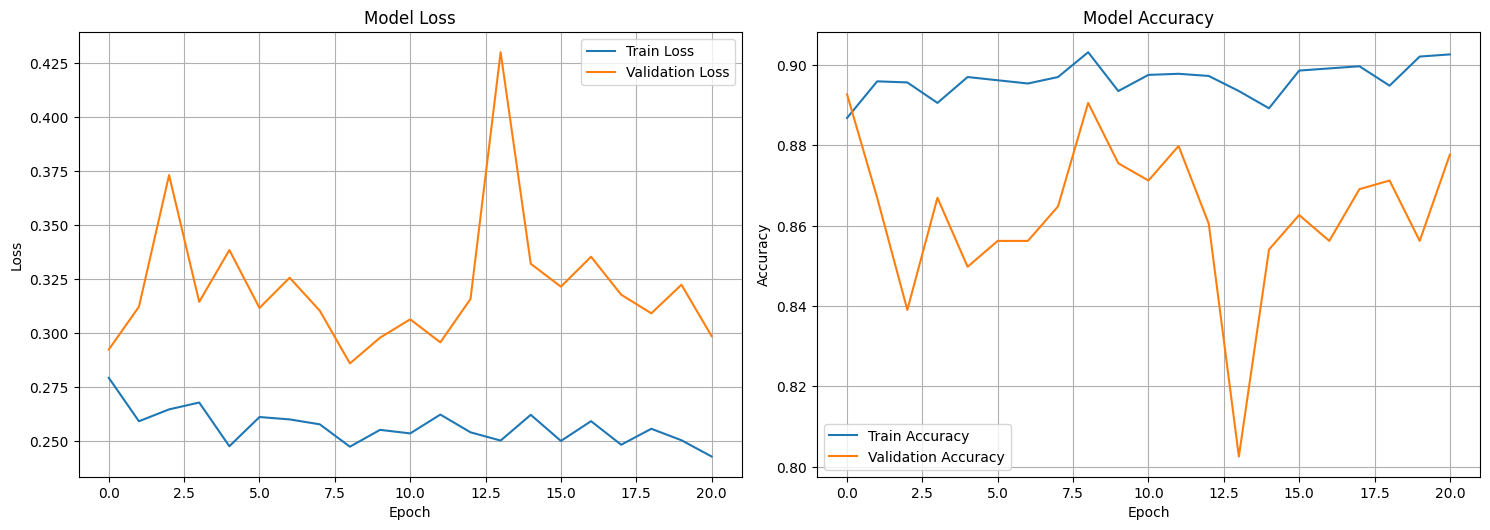

In [ ]:
plot_history(history)

#OLD
- bestweights.pth for this older version but performs the best

KEEP THIS

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, dim, dropout=0.4):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim)
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.layers(x)
        out += residual  # Residual connection
        return self.relu(out)

class v1DeepResClassifier(nn.Module):
    def __init__(self, input_dim=1024, output_dim=1, hidden_dim=624, num_layers=3):
        super().__init__()

        # Input projection
        self.input_projection = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.4)
        )

        # residual layers (num_layers)
        self.residual_layers = nn.ModuleList([
            ResidualBlock(hidden_dim, dropout=0.4) for _ in range(num_layers)
        ])

        # Output head
        self.output_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim // 2, output_dim)
        )

    def forward(self, x):
        # Input projection
        x = self.input_projection(x)

        # Apply residual layers
        for residual_block in self.residual_layers:
            x = residual_block(x)


        return self.output_head(x)

In [ ]:
### DEFINE MODEL, LOSS & OPTIMIZER

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DeepResClassifier(input_dim=1024).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [ ]:

# ---------- setup ----------
epochs = 100
patience = 10
best_val_acc = 0.0
counter = 0
best_wts = copy.deepcopy(model.state_dict())

#mode = min --> when monitoring loss
#mode = max --> when monitoring accuracy
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3, min_lr=1e-6)

history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}


# ---------- training loop ----------
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    all_train_preds = []
    all_train_labels = []

    for Xb, yb in train_dataloader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()

        logits = model(Xb)
        loss = criterion(logits, yb.unsqueeze(1))  # ensure same shape
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * Xb.size(0)
        all_train_preds.append(logits.detach())
        all_train_labels.append(yb)

    avg_train_loss = total_loss / len(train_dataloader.dataset)
    train_logits = torch.cat(all_train_preds)
    train_labels = torch.cat(all_train_labels)
    train_metrics = metrics(train_labels, torch.sigmoid(train_logits))

    # ---------- validation ----------
    model.eval()
    val_loss = 0.0
    all_val_preds = []
    all_val_labels = []

    with torch.no_grad():
        for Xb, yb in val_dataloader:
            Xb, yb = Xb.to(device), yb.to(device)
            logits = model(Xb)
            loss = criterion(logits, yb.unsqueeze(1))
            val_loss += loss.item() * Xb.size(0)
            all_val_preds.append(logits)
            all_val_labels.append(yb)

    avg_val_loss = val_loss / len(val_dataloader.dataset)
    val_logits = torch.cat(all_val_preds)
    val_labels = torch.cat(all_val_labels)
    val_metrics = metrics(val_labels, torch.sigmoid(val_logits))

    # ---------- scheduler + early stopping ----------
    scheduler.step(val_metrics["accuracy"])

    history["train_loss"].append(avg_train_loss)
    history["val_loss"].append(avg_val_loss)
    history["train_acc"].append(train_metrics["accuracy"])
    history["val_acc"].append(val_metrics["accuracy"])

    print(f"Epoch {epoch+1:03d} | "
          f"TrainLoss {avg_train_loss:.4f} | ValLoss {avg_val_loss:.4f} | "
          f"TrainAcc {train_metrics['accuracy']:.4f} | ValAcc {val_metrics['accuracy']:.4f}")

    # Early stopping on val acc
    if val_metrics["accuracy"] > best_val_acc:
        best_val_acc = val_metrics["accuracy"]
        best_wts = copy.deepcopy(model.state_dict())
        counter = 0
        torch.save(best_wts, "best_binary_model_acc.pth")
        print(f"New best val acc: {best_val_acc:.4f}")

        torch.save(model.state_dict(), "/content/drive/MyDrive/715/model_weights/weights.pth")


    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}, (no improvement for {patience} epochs)")
            break

# ---------- restore best weights ----------
model.load_state_dict(best_wts)
print(f"Best validation accuracy: {best_val_acc:.4f}")
print(f"avg train loss: {avg_train_loss:.4f} | avg val loss: {avg_val_loss:.4f}")



Epoch 001 | TrainLoss 0.4496 | ValLoss 0.3626 | TrainAcc 0.7913 | ValAcc 0.8348
New best val acc: 0.8348
Epoch 002 | TrainLoss 0.3830 | ValLoss 0.3356 | TrainAcc 0.8246 | ValAcc 0.8476
New best val acc: 0.8476
Epoch 003 | TrainLoss 0.3448 | ValLoss 0.3134 | TrainAcc 0.8492 | ValAcc 0.8627
New best val acc: 0.8627
Epoch 004 | TrainLoss 0.3399 | ValLoss 0.3833 | TrainAcc 0.8554 | ValAcc 0.8305
Epoch 005 | TrainLoss 0.3180 | ValLoss 0.3499 | TrainAcc 0.8653 | ValAcc 0.8605
Epoch 006 | TrainLoss 0.2999 | ValLoss 0.3283 | TrainAcc 0.8780 | ValAcc 0.8691
New best val acc: 0.8691
Epoch 007 | TrainLoss 0.2906 | ValLoss 0.3169 | TrainAcc 0.8761 | ValAcc 0.8712
New best val acc: 0.8712
Epoch 008 | TrainLoss 0.2950 | ValLoss 0.3001 | TrainAcc 0.8726 | ValAcc 0.8627
Epoch 009 | TrainLoss 0.2585 | ValLoss 0.2890 | TrainAcc 0.8873 | ValAcc 0.8734
New best val acc: 0.8734
Epoch 010 | TrainLoss 0.2554 | ValLoss 0.2766 | TrainAcc 0.8930 | ValAcc 0.8691
Epoch 011 | TrainLoss 0.2411 | ValLoss 0.2946 | Tr

# EVALUATE

## Evaluate on s. cerevisae test

In [ ]:
model.eval()
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for Xb, yb in test_dataloader:
        Xb, yb = Xb.float().to(device), yb.to(device)

        # Forward pass → model returns logits only
        y_logits = model(Xb)

        # Convert logits → probabilities
        y_pred = torch.sigmoid(y_logits)

        # Store predictions and labels
        all_test_preds.append(y_pred.cpu())
        all_test_labels.append(yb.cpu())

# Concatenate across batches
all_test_preds = torch.cat(all_test_preds, dim=0)      # shape (N, 1)
all_test_labels = torch.cat(all_test_labels, dim=0)    # shape (N, 1)

# Convert to numpy
y_scores = all_test_preds.numpy()
y_test   = all_test_labels.numpy()

print("Preds:", y_scores.shape, "Labels:", y_test.shape)

Preds: (466, 1) Labels: (466,)


In [ ]:
test_metrics = metrics(y_test, all_test_preds)  # DO NOT apply sigmoid again

for k, v in test_metrics.items():
    if isinstance(v, (float, int)):
        print(f"{k}: {v:.4f}")
    elif isinstance(v, np.ndarray):  ##for confusion matrix
        print(f"{k}:\n{v}")
    else:
        print(f"{k}: {v}")

accuracy: 0.8369
f1: 0.8345
confusion_matrix:
[[167  66]
 [ 10 223]]
auc_score: 0.9384
recall_score: 0.9571
precision_score: 0.7716


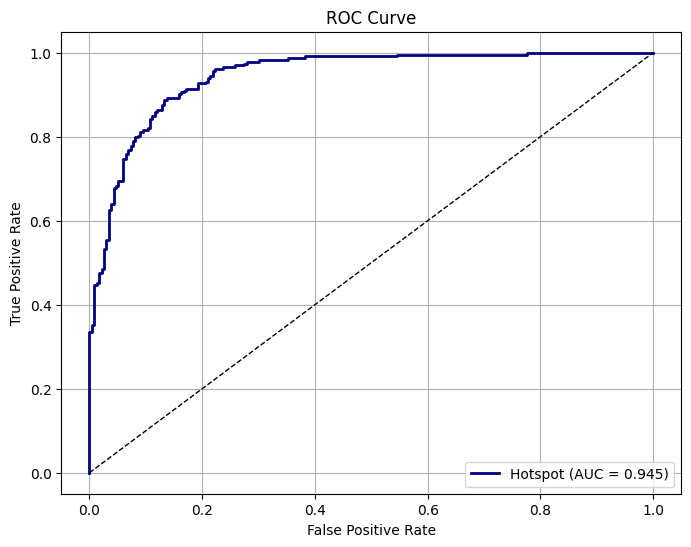

AUC = 0.945


In [ ]:
plot_roc(y_test, all_test_preds)

## Evaulate on S. paradoxus

In [ ]:
spar_data  = BinaryDataset("/content/drive/MyDrive/715/paradoxus/spar_embeddings.npy",
                               "/content/drive/MyDrive/715/paradoxus/spar_labels.npy")

spar_dataloader = DataLoader(spar_data,
                              batch_size = 16,
                              shuffle = True,
                              drop_last = True)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DeepResClassifier(input_dim=1024, output_dim=1)
model.load_state_dict(torch.load("/content/drive/MyDrive/715/model_weights/bestweights.pth", map_location=device))
model.to(device)
model.eval()

DeepResClassifier(
  (input_projection): Sequential(
    (0): Linear(in_features=1024, out_features=624, bias=True)
    (1): BatchNorm1d(624, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
  )
  (residual_layers): ModuleList(
    (0-2): 3 x ResidualBlock(
      (layers): Sequential(
        (0): Linear(in_features=624, out_features=624, bias=True)
        (1): BatchNorm1d(624, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.4, inplace=False)
        (4): Linear(in_features=624, out_features=624, bias=True)
        (5): BatchNorm1d(624, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
  )
  (output_head): Sequential(
    (0): Linear(in_features=624, out_features=312, bias=True)
    (1): BatchNorm1d(312, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.4, i

In [ ]:
print(model.__class__.__name__)

DeepResClassifier


In [ ]:
model.eval()
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for Xb, yb in spar_dataloader:
        Xb, yb = Xb.float().to(device), yb.to(device)

        # Forward pass → model returns logits only
        y_logits = model(Xb)

        # Convert logits → probabilities
        y_pred = torch.sigmoid(y_logits)

        # Store predictions and labels
        all_test_preds.append(y_pred.cpu())
        all_test_labels.append(yb.cpu())

# Concatenate across batches
all_test_preds = torch.cat(all_test_preds, dim=0)      # shape (N, 1)
all_test_labels = torch.cat(all_test_labels, dim=0)    # shape (N, 1)

# Convert to numpy
y_scores = all_test_preds.numpy()
y_test   = all_test_labels.numpy()

print("Preds:", y_scores.shape, "Labels:", y_test.shape)

Preds: (4368, 1) Labels: (4368,)


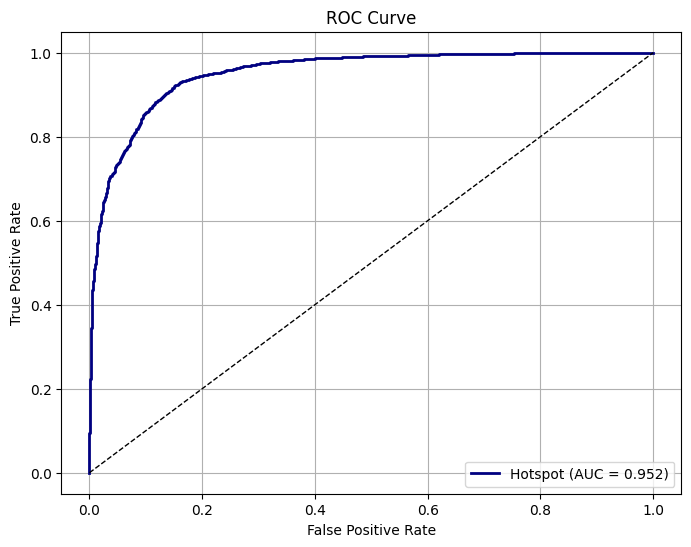

AUC = 0.952


In [ ]:
plot_roc(y_test, all_test_preds)

In [ ]:
test_metrics = metrics(y_test, all_test_preds)  # DO NOT apply sigmoid again

for k, v in test_metrics.items():
    if isinstance(v, (float, int)):
        print(f"{k}: {v:.4f}")
    elif isinstance(v, np.ndarray):  ##for confusion matrix
        print(f"{k}:\n{v}")
    else:
        print(f"{k}: {v}")

accuracy: 0.8821
f1: 0.8820
confusion_matrix:
[[1873  264]
 [ 251 1980]]
auc_score: 0.8820
recall_score: 0.8875
precision_score: 0.8824


## Evaluate on S. mikatae

In [ ]:
smik_data = BinaryDataset("/content/drive/MyDrive/715/Smik/smik_embeddings.npy",
                               "/content/drive/MyDrive/715/Smik/smik_labels.npy")

smik_dataloader = DataLoader(smik_data,
                              batch_size = 16,
                              shuffle = True,
                              drop_last = True)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DeepResClassifier(input_dim=1024, output_dim=1)
model.load_state_dict(torch.load("/content/drive/MyDrive/715/model_weights/bestweights.pth", map_location=device))
model.to(device)
model.eval()

DeepResClassifier(
  (input_projection): Sequential(
    (0): Linear(in_features=1024, out_features=624, bias=True)
    (1): BatchNorm1d(624, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
  )
  (residual_layers): ModuleList(
    (0-2): 3 x ResidualBlock(
      (layers): Sequential(
        (0): Linear(in_features=624, out_features=624, bias=True)
        (1): BatchNorm1d(624, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.4, inplace=False)
        (4): Linear(in_features=624, out_features=624, bias=True)
        (5): BatchNorm1d(624, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
  )
  (output_head): Sequential(
    (0): Linear(in_features=624, out_features=312, bias=True)
    (1): BatchNorm1d(312, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.4, i

In [ ]:
print(model.__class__.__name__)

DeepResClassifier


In [ ]:
model.eval()
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for Xb, yb in smik_dataloader:
        Xb, yb = Xb.float().to(device), yb.to(device)

        # Forward pass → model returns logits only
        y_logits = model(Xb)

        # Convert logits → probabilities
        y_pred = torch.sigmoid(y_logits)

        # Store predictions and labels
        all_test_preds.append(y_pred.cpu())
        all_test_labels.append(yb.cpu())

# Concatenate across batches
all_test_preds = torch.cat(all_test_preds, dim=0)      # shape (N, 1)
all_test_labels = torch.cat(all_test_labels, dim=0)    # shape (N, 1)

# Convert to numpy
y_scores = all_test_preds.numpy()
y_test   = all_test_labels.numpy()

print("Preds:", y_scores.shape, "Labels:", y_test.shape)

Preds: (4560, 1) Labels: (4560,)


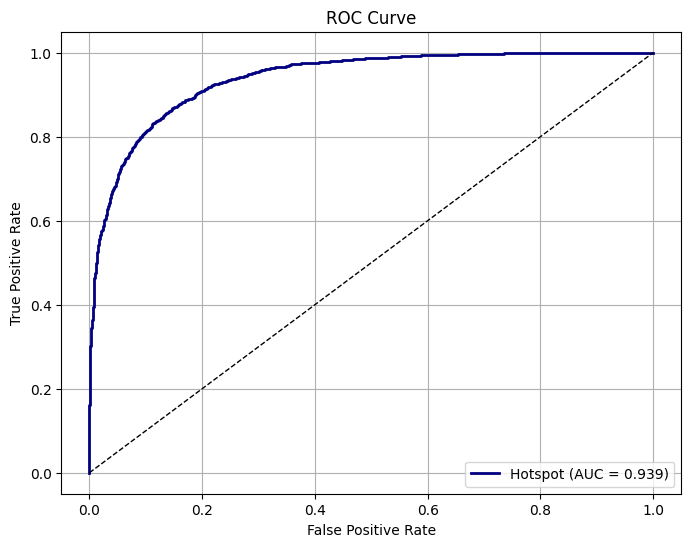

AUC = 0.939


In [ ]:
plot_roc(y_test, all_test_preds)

In [ ]:
test_metrics = metrics(y_test, all_test_preds)  # DO NOT apply sigmoid again

for k, v in test_metrics.items():
    if isinstance(v, (float, int)):
        print(f"{k}: {v:.4f}")
    elif isinstance(v, np.ndarray):  ##for confusion matrix
        print(f"{k}:\n{v}")
    else:
        print(f"{k}: {v}")

accuracy: 0.8586
f1: 0.8585
confusion_matrix:
[[1991  295]
 [ 350 1924]]
auc_score: 0.8585
recall_score: 0.8461
precision_score: 0.8671


## Evaluate on S. kudriavzevii


In [ ]:
skud_data = BinaryDataset("/content/drive/MyDrive/715/Skud/skud_embeddings.npy",
                                "/content/drive/MyDrive/715/Skud/skud_labels.npy")

skud_dataloader = DataLoader(skud_data,
                              batch_size = 16,
                              shuffle = True,
                              drop_last = True)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DeepResClassifier(input_dim=1024, output_dim=1)
model.load_state_dict(torch.load("/content/drive/MyDrive/715/model_weights/bestweights.pth", map_location=device))
model.to(device)
model.eval()

DeepResClassifier(
  (input_projection): Sequential(
    (0): Linear(in_features=1024, out_features=624, bias=True)
    (1): BatchNorm1d(624, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
  )
  (residual_layers): ModuleList(
    (0-2): 3 x ResidualBlock(
      (layers): Sequential(
        (0): Linear(in_features=624, out_features=624, bias=True)
        (1): BatchNorm1d(624, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.4, inplace=False)
        (4): Linear(in_features=624, out_features=624, bias=True)
        (5): BatchNorm1d(624, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
  )
  (output_head): Sequential(
    (0): Linear(in_features=624, out_features=312, bias=True)
    (1): BatchNorm1d(312, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.4, i

In [ ]:
print(model.__class__.__name__)

DeepResClassifier


In [ ]:
model.eval()
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for Xb, yb in skud_dataloader:
        Xb, yb = Xb.float().to(device), yb.to(device)

        # Forward pass → model returns logits only
        y_logits = model(Xb)

        # Convert logits → probabilities
        y_pred = torch.sigmoid(y_logits)

        # Store predictions and labels
        all_test_preds.append(y_pred.cpu())
        all_test_labels.append(yb.cpu())

# Concatenate across batches
all_test_preds = torch.cat(all_test_preds, dim=0)      # shape (N, 1)
all_test_labels = torch.cat(all_test_labels, dim=0)    # shape (N, 1)

# Convert to numpy
y_scores = all_test_preds.numpy()
y_test   = all_test_labels.numpy()

print("Preds:", y_scores.shape, "Labels:", y_test.shape)

Preds: (4416, 1) Labels: (4416,)


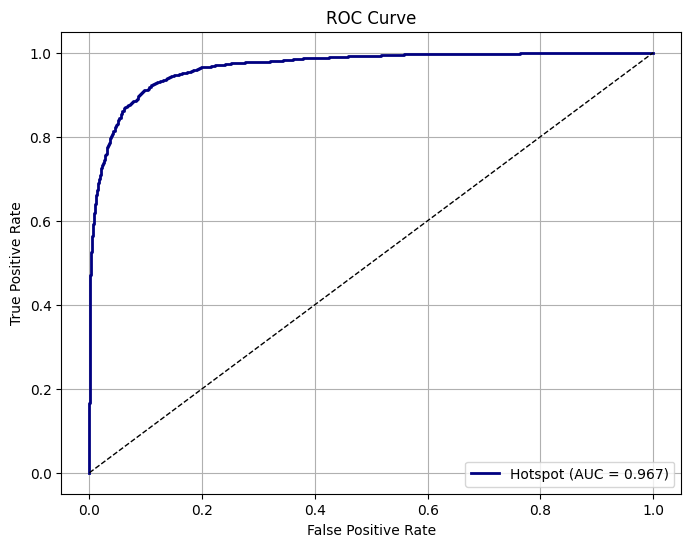

AUC = 0.967


In [ ]:
plot_roc(y_test, all_test_preds)

In [ ]:
test_metrics = metrics(y_test, all_test_preds)  # DO NOT apply sigmoid again

for k, v in test_metrics.items():
    if isinstance(v, (float, int)):
        print(f"{k}: {v:.4f}")
    elif isinstance(v, np.ndarray):  ##for confusion matrix
        print(f"{k}:\n{v}")
    else:
        print(f"{k}: {v}")

accuracy: 0.9013
f1: 0.9012
confusion_matrix:
[[1939  290]
 [ 146 2041]]
auc_score: 0.9016
recall_score: 0.9332
precision_score: 0.8756
